### Generate MNIST image with Keras implementation of GAN


GAN contains two parts: Generator(G) and Discriminator(D). In this scenario, a Generator takes in a random vector and outputs an image, a Discriminator takes in an image and outputs a probability (the image is a real image or not).

![](training_discriminator.png)
When training D, we feed in images (both real and generated) and labels like training a normal image classifier.


![](training_generator.png)
When training G, we freeze the weights of D and set the final output label as real image. Then the G will adjust its weights trying to cheat D, in other words, generating "better" image.

In [1]:
import numpy as np
import os
from keras.preprocessing import image
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train.flatten() == 0]
x_train.shape

(5923, 28, 28)

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

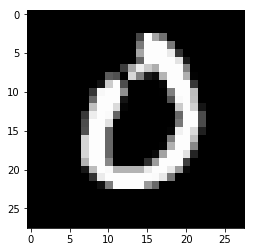

In [4]:
plt.imshow(x_train[20], cmap='gray')

In [5]:
from keras.layers import Input, Conv2D, Dense, Reshape, Activation, LeakyReLU, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam

In [6]:
# generator
INPUT_SIZE = 10

g_input = Input(shape=(INPUT_SIZE,))
x = Dense(28*28*16)(g_input)
x = Reshape((28,28,16))(x)
x = Conv2D(32, 3, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(128, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(128, 7, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(1, 3, padding='same', activation='tanh')(x)

generator = Model(g_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             137984    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
__________

In [7]:
# discriminator
d_input = Input(shape=(28,28,1))
x = Reshape((28*28,))(d_input)
x = Dense(1024)(x)
x = LeakyReLU(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU(0.2)(x)
x = Dense(256)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(d_input, x)
discriminator.summary()

discriminator_optimizer = Adam(lr=0.0003)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
__________

In [8]:
# GAN
discriminator.trainable = False
gan_input = Input((INPUT_SIZE,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.summary()
opt = Adam(lr=0.0003)
gan.compile(optimizer=opt, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1170145   
_________________________________________________________________
model_2 (Model)              (None, 1)                 1460225   
Total params: 2,630,370
Trainable params: 1,170,145
Non-trainable params: 1,460,225
_________________________________________________________________


In [9]:
iterations = 10000
BATCH_SIZE = 16
# (x_train.shape[0], 28, 28, 1)
height = 28
width = 28
channels = 1
d_losses = []
g_losses = []
# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

save_dir = './mnist_generated_img_cnn/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for step in tqdm(range(iterations)):
    random_input = np.random.normal(size=(BATCH_SIZE, INPUT_SIZE))
    generated_images = generator.predict(random_input)
    ind = np.random.choice(x_train.shape[0], BATCH_SIZE)
    train_data = np.concatenate([generated_images, x_train[ind]])

    train_label = np.concatenate([np.ones((BATCH_SIZE, 1)), np.zeros((BATCH_SIZE,1))])
    # Add random noise to the labels
    train_label += 0.05 * np.random.random(train_label.shape)

    # training discriminator
    d_loss = discriminator.train_on_batch(train_data, train_label)
    d_losses.append(d_loss)
    
    # training generator
    random_input = np.random.normal(size=(BATCH_SIZE, INPUT_SIZE))
    fake_label = np.zeros((BATCH_SIZE,1))
    loss = gan.train_on_batch(random_input, fake_label)
    g_losses.append(loss)
    
    if step % 100 == 0:
        # Save model weights
        gan.save('mnist_gan.h5')
        
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('GAN loss at step %s: %s' % (step, loss))
        img = generated_images[0] * 255.
        img = image.array_to_img(img, scale=False)
        img.save(os.path.join(save_dir, 'image' + str(step) + '.png'))
        

        

  0%|          | 0/10000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/10000 [00:05<14:24:07,  5.19s/it]

discriminator loss at step 0: 0.65787476
GAN loss at step 0: 0.68449277


  1%|          | 101/10000 [02:01<3:17:41,  1.20s/it]

discriminator loss at step 100: 0.9575348
GAN loss at step 100: 1.3507822


  2%|▏         | 201/10000 [04:00<3:15:14,  1.20s/it]

discriminator loss at step 200: 1.1839213
GAN loss at step 200: 0.7855773


  3%|▎         | 301/10000 [05:59<3:12:54,  1.19s/it]

discriminator loss at step 300: 1.5131919
GAN loss at step 300: 1.3520938


  4%|▍         | 401/10000 [07:58<3:10:42,  1.19s/it]

discriminator loss at step 400: 0.43293586
GAN loss at step 400: 4.0103164


  5%|▌         | 501/10000 [09:57<3:08:46,  1.19s/it]

discriminator loss at step 500: 0.5428278
GAN loss at step 500: 1.1628804


  6%|▌         | 601/10000 [11:53<3:05:55,  1.19s/it]

discriminator loss at step 600: 0.52242327
GAN loss at step 600: 2.1805058


  7%|▋         | 701/10000 [13:50<3:03:35,  1.18s/it]

discriminator loss at step 700: 0.8280202
GAN loss at step 700: 0.9382901


  8%|▊         | 801/10000 [15:48<3:01:27,  1.18s/it]

discriminator loss at step 800: 0.8098898
GAN loss at step 800: 1.3130326


  9%|▉         | 901/10000 [17:46<2:59:28,  1.18s/it]

discriminator loss at step 900: 0.8330189
GAN loss at step 900: 1.1060693


 10%|█         | 1001/10000 [19:46<2:57:47,  1.19s/it]

discriminator loss at step 1000: 0.6223454
GAN loss at step 1000: 1.4344858


 11%|█         | 1101/10000 [21:43<2:55:33,  1.18s/it]

discriminator loss at step 1100: 0.89027745
GAN loss at step 1100: 0.6396313


 12%|█▏        | 1201/10000 [23:38<2:53:15,  1.18s/it]

discriminator loss at step 1200: 0.6376052
GAN loss at step 1200: 0.8690798


 13%|█▎        | 1301/10000 [25:34<2:51:00,  1.18s/it]

discriminator loss at step 1300: 0.42132032
GAN loss at step 1300: 1.11677


 14%|█▍        | 1401/10000 [27:30<2:48:48,  1.18s/it]

discriminator loss at step 1400: 0.62522066
GAN loss at step 1400: 1.2974191


 15%|█▌        | 1501/10000 [29:26<2:46:42,  1.18s/it]

discriminator loss at step 1500: 0.931774
GAN loss at step 1500: 0.6166661


 16%|█▌        | 1601/10000 [31:22<2:44:37,  1.18s/it]

discriminator loss at step 1600: 0.8760513
GAN loss at step 1600: 0.55044466


 17%|█▋        | 1701/10000 [33:19<2:42:37,  1.18s/it]

discriminator loss at step 1700: 0.5516925
GAN loss at step 1700: 0.7945477


 18%|█▊        | 1801/10000 [35:15<2:40:31,  1.17s/it]

discriminator loss at step 1800: 0.5580172
GAN loss at step 1800: 1.6988425


 19%|█▉        | 1901/10000 [37:11<2:38:25,  1.17s/it]

discriminator loss at step 1900: 0.6876317
GAN loss at step 1900: 0.8421008


 20%|██        | 2001/10000 [39:06<2:36:20,  1.17s/it]

discriminator loss at step 2000: 0.5905615
GAN loss at step 2000: 1.3880081


 21%|██        | 2101/10000 [41:02<2:34:16,  1.17s/it]

discriminator loss at step 2100: 0.56797534
GAN loss at step 2100: 0.90174615


 22%|██▏       | 2201/10000 [42:57<2:32:13,  1.17s/it]

discriminator loss at step 2200: 0.622743
GAN loss at step 2200: 1.1240065


 23%|██▎       | 2301/10000 [44:52<2:30:07,  1.17s/it]

discriminator loss at step 2300: 0.767172
GAN loss at step 2300: 0.7377082


 24%|██▍       | 2401/10000 [46:45<2:28:00,  1.17s/it]

discriminator loss at step 2400: 0.5997428
GAN loss at step 2400: 0.94599354


 25%|██▌       | 2501/10000 [48:39<2:25:52,  1.17s/it]

discriminator loss at step 2500: 0.643659
GAN loss at step 2500: 0.71901935


 26%|██▌       | 2601/10000 [50:32<2:23:46,  1.17s/it]

discriminator loss at step 2600: 0.30963108
GAN loss at step 2600: 1.7540586


 27%|██▋       | 2701/10000 [52:25<2:21:41,  1.16s/it]

discriminator loss at step 2700: 0.33905688
GAN loss at step 2700: 1.7762467


 28%|██▊       | 2801/10000 [54:19<2:19:36,  1.16s/it]

discriminator loss at step 2800: 0.56258976
GAN loss at step 2800: 1.2727072


 29%|██▉       | 2901/10000 [56:12<2:17:32,  1.16s/it]

discriminator loss at step 2900: 0.4964482
GAN loss at step 2900: 1.0597234


 30%|███       | 3001/10000 [58:05<2:15:29,  1.16s/it]

discriminator loss at step 3000: 0.54991865
GAN loss at step 3000: 1.3568419


 31%|███       | 3101/10000 [59:59<2:13:27,  1.16s/it]

discriminator loss at step 3100: 0.50960135
GAN loss at step 3100: 1.0778434


 32%|███▏      | 3201/10000 [1:01:52<2:11:25,  1.16s/it]

discriminator loss at step 3200: 0.38416594
GAN loss at step 3200: 1.4153576


 33%|███▎      | 3301/10000 [1:03:45<2:09:23,  1.16s/it]

discriminator loss at step 3300: 0.43193486
GAN loss at step 3300: 1.271985


 34%|███▍      | 3401/10000 [1:05:38<2:07:22,  1.16s/it]

discriminator loss at step 3400: 0.33676428
GAN loss at step 3400: 1.1502292


 35%|███▌      | 3501/10000 [1:07:32<2:05:22,  1.16s/it]

discriminator loss at step 3500: 0.30961642
GAN loss at step 3500: 2.0733209


 36%|███▌      | 3601/10000 [1:09:25<2:03:21,  1.16s/it]

discriminator loss at step 3600: 0.33125737
GAN loss at step 3600: 1.9149555


 37%|███▋      | 3701/10000 [1:11:18<2:01:22,  1.16s/it]

discriminator loss at step 3700: 0.40128306
GAN loss at step 3700: 3.4161444


 38%|███▊      | 3801/10000 [1:13:11<1:59:22,  1.16s/it]

discriminator loss at step 3800: 0.46828586
GAN loss at step 3800: 1.3508873


 39%|███▉      | 3901/10000 [1:15:04<1:57:23,  1.15s/it]

discriminator loss at step 3900: 0.30429202
GAN loss at step 3900: 1.6882491


 40%|████      | 4001/10000 [1:16:58<1:55:24,  1.15s/it]

discriminator loss at step 4000: 0.57258916
GAN loss at step 4000: 1.1487129


 41%|████      | 4101/10000 [1:18:51<1:53:26,  1.15s/it]

discriminator loss at step 4100: 0.32509574
GAN loss at step 4100: 1.8165636


 42%|████▏     | 4201/10000 [1:20:44<1:51:27,  1.15s/it]

discriminator loss at step 4200: 0.5495028
GAN loss at step 4200: 1.9462034


 43%|████▎     | 4301/10000 [1:22:38<1:49:29,  1.15s/it]

discriminator loss at step 4300: 0.23423702
GAN loss at step 4300: 2.756609


 44%|████▍     | 4401/10000 [1:24:31<1:47:31,  1.15s/it]

discriminator loss at step 4400: 0.4352963
GAN loss at step 4400: 1.5765994


 45%|████▌     | 4501/10000 [1:26:24<1:45:34,  1.15s/it]

discriminator loss at step 4500: 0.74103886
GAN loss at step 4500: 1.4439238


 46%|████▌     | 4601/10000 [1:28:18<1:43:36,  1.15s/it]

discriminator loss at step 4600: 0.37618905
GAN loss at step 4600: 2.131921


 47%|████▋     | 4701/10000 [1:30:11<1:41:39,  1.15s/it]

discriminator loss at step 4700: 0.47983116
GAN loss at step 4700: 2.6303782


 48%|████▊     | 4801/10000 [1:32:04<1:39:42,  1.15s/it]

discriminator loss at step 4800: 0.4057845
GAN loss at step 4800: 1.3101292


 49%|████▉     | 4901/10000 [1:33:57<1:37:45,  1.15s/it]

discriminator loss at step 4900: 0.77228856
GAN loss at step 4900: 1.9300754


 50%|█████     | 5001/10000 [1:35:51<1:35:48,  1.15s/it]

discriminator loss at step 5000: 0.42267218
GAN loss at step 5000: 1.9526912


 51%|█████     | 5101/10000 [1:37:44<1:33:52,  1.15s/it]

discriminator loss at step 5100: 0.4603038
GAN loss at step 5100: 2.372841


 52%|█████▏    | 5201/10000 [1:39:37<1:31:55,  1.15s/it]

discriminator loss at step 5200: 0.63825846
GAN loss at step 5200: 2.7046585


 53%|█████▎    | 5301/10000 [1:41:31<1:29:59,  1.15s/it]

discriminator loss at step 5300: 0.57025176
GAN loss at step 5300: 1.6453536


 54%|█████▍    | 5401/10000 [1:43:24<1:28:03,  1.15s/it]

discriminator loss at step 5400: 0.20216973
GAN loss at step 5400: 3.6419888


 55%|█████▌    | 5501/10000 [1:45:17<1:26:06,  1.15s/it]

discriminator loss at step 5500: 0.6463727
GAN loss at step 5500: 3.0431046


 56%|█████▌    | 5601/10000 [1:47:11<1:24:10,  1.15s/it]

discriminator loss at step 5600: 0.19188769
GAN loss at step 5600: 2.1262364


 57%|█████▋    | 5701/10000 [1:49:04<1:22:14,  1.15s/it]

discriminator loss at step 5700: 0.635229
GAN loss at step 5700: 1.7022035


 58%|█████▊    | 5801/10000 [1:50:57<1:20:19,  1.15s/it]

discriminator loss at step 5800: 0.5614867
GAN loss at step 5800: 2.0458806


 59%|█████▉    | 5901/10000 [1:52:50<1:18:23,  1.15s/it]

discriminator loss at step 5900: 0.7220901
GAN loss at step 5900: 1.1127234


 60%|██████    | 6001/10000 [1:54:44<1:16:27,  1.15s/it]

discriminator loss at step 6000: 0.50464255
GAN loss at step 6000: 2.5236351


 61%|██████    | 6101/10000 [1:56:37<1:14:32,  1.15s/it]

discriminator loss at step 6100: 0.45713556
GAN loss at step 6100: 1.8457556


 62%|██████▏   | 6201/10000 [1:58:30<1:12:36,  1.15s/it]

discriminator loss at step 6200: 0.44547272
GAN loss at step 6200: 2.5771077


 63%|██████▎   | 6301/10000 [2:00:24<1:10:41,  1.15s/it]

discriminator loss at step 6300: 0.51446664
GAN loss at step 6300: 1.1078248


 64%|██████▍   | 6401/10000 [2:02:17<1:08:45,  1.15s/it]

discriminator loss at step 6400: 0.19191784
GAN loss at step 6400: 3.1423216


 65%|██████▌   | 6501/10000 [2:04:11<1:06:50,  1.15s/it]

discriminator loss at step 6500: 0.39581406
GAN loss at step 6500: 2.476971


 66%|██████▌   | 6601/10000 [2:06:04<1:04:55,  1.15s/it]

discriminator loss at step 6600: 0.08215787
GAN loss at step 6600: 4.5742254


 67%|██████▋   | 6701/10000 [2:07:57<1:02:59,  1.15s/it]

discriminator loss at step 6700: 0.26768556
GAN loss at step 6700: 1.7076223


 68%|██████▊   | 6801/10000 [2:09:50<1:01:04,  1.15s/it]

discriminator loss at step 6800: 0.36076146
GAN loss at step 6800: 1.48954


 69%|██████▉   | 6901/10000 [2:11:44<59:09,  1.15s/it]  

discriminator loss at step 6900: 0.400303
GAN loss at step 6900: 2.0717993


 70%|███████   | 7001/10000 [2:13:37<57:14,  1.15s/it]

discriminator loss at step 7000: 0.24038987
GAN loss at step 7000: 4.280484


 71%|███████   | 7101/10000 [2:15:31<55:19,  1.15s/it]

discriminator loss at step 7100: 0.37972313
GAN loss at step 7100: 3.8927069


 72%|███████▏  | 7201/10000 [2:17:24<53:24,  1.14s/it]

discriminator loss at step 7200: 0.18021886
GAN loss at step 7200: 3.9740574


 73%|███████▎  | 7301/10000 [2:19:17<51:29,  1.14s/it]

discriminator loss at step 7300: 0.26573396
GAN loss at step 7300: 3.9935472


 74%|███████▍  | 7401/10000 [2:21:10<49:34,  1.14s/it]

discriminator loss at step 7400: 0.33384898
GAN loss at step 7400: 1.9512684


 75%|███████▌  | 7501/10000 [2:23:04<47:39,  1.14s/it]

discriminator loss at step 7500: 0.23657373
GAN loss at step 7500: 6.4154677


 76%|███████▌  | 7601/10000 [2:24:57<45:45,  1.14s/it]

discriminator loss at step 7600: 0.17609638
GAN loss at step 7600: 4.6488156


 77%|███████▋  | 7701/10000 [2:26:50<43:50,  1.14s/it]

discriminator loss at step 7700: 0.57682455
GAN loss at step 7700: 3.3931298


 78%|███████▊  | 7801/10000 [2:28:44<41:55,  1.14s/it]

discriminator loss at step 7800: 0.37616903
GAN loss at step 7800: 3.4873447


 79%|███████▉  | 7901/10000 [2:30:37<40:00,  1.14s/it]

discriminator loss at step 7900: 0.31291348
GAN loss at step 7900: 2.8292644


 80%|████████  | 8001/10000 [2:32:30<38:06,  1.14s/it]

discriminator loss at step 8000: 0.27167436
GAN loss at step 8000: 3.4080667


 81%|████████  | 8101/10000 [2:34:24<36:11,  1.14s/it]

discriminator loss at step 8100: 0.38788363
GAN loss at step 8100: 3.322002


 82%|████████▏ | 8201/10000 [2:36:17<34:17,  1.14s/it]

discriminator loss at step 8200: 0.5814409
GAN loss at step 8200: 4.7744017


 83%|████████▎ | 8301/10000 [2:38:11<32:22,  1.14s/it]

discriminator loss at step 8300: 0.66730595
GAN loss at step 8300: 2.7054086


 84%|████████▍ | 8401/10000 [2:40:04<30:28,  1.14s/it]

discriminator loss at step 8400: 0.23390228
GAN loss at step 8400: 4.609437


 85%|████████▌ | 8501/10000 [2:41:57<28:33,  1.14s/it]

discriminator loss at step 8500: 0.287803
GAN loss at step 8500: 5.2079983


 86%|████████▌ | 8601/10000 [2:43:51<26:39,  1.14s/it]

discriminator loss at step 8600: 0.26180062
GAN loss at step 8600: 2.0066366


 87%|████████▋ | 8701/10000 [2:45:44<24:44,  1.14s/it]

discriminator loss at step 8700: 0.22937188
GAN loss at step 8700: 5.0633354


 88%|████████▊ | 8801/10000 [2:47:37<22:50,  1.14s/it]

discriminator loss at step 8800: 0.20766088
GAN loss at step 8800: 2.9672868


 89%|████████▉ | 8901/10000 [2:49:31<20:55,  1.14s/it]

discriminator loss at step 8900: 0.74311155
GAN loss at step 8900: 2.4957504


 90%|█████████ | 9001/10000 [2:51:25<19:01,  1.14s/it]

discriminator loss at step 9000: 0.3423038
GAN loss at step 9000: 2.674811


 91%|█████████ | 9101/10000 [2:53:18<17:07,  1.14s/it]

discriminator loss at step 9100: 0.21606493
GAN loss at step 9100: 4.631828


 92%|█████████▏| 9201/10000 [2:55:11<15:12,  1.14s/it]

discriminator loss at step 9200: 0.20188436
GAN loss at step 9200: 3.9994116


 93%|█████████▎| 9301/10000 [2:57:05<13:18,  1.14s/it]

discriminator loss at step 9300: 0.37920558
GAN loss at step 9300: 3.5789297


 94%|█████████▍| 9401/10000 [2:58:58<11:24,  1.14s/it]

discriminator loss at step 9400: 0.08778085
GAN loss at step 9400: 6.7565618


 95%|█████████▌| 9501/10000 [3:00:52<09:29,  1.14s/it]

discriminator loss at step 9500: 0.46133825
GAN loss at step 9500: 3.6696038


 96%|█████████▌| 9601/10000 [3:02:45<07:35,  1.14s/it]

discriminator loss at step 9600: 0.31536523
GAN loss at step 9600: 2.8784163


 97%|█████████▋| 9701/10000 [3:04:39<05:41,  1.14s/it]

discriminator loss at step 9700: 0.41428086
GAN loss at step 9700: 4.5763683


 98%|█████████▊| 9801/10000 [3:06:33<03:47,  1.14s/it]

discriminator loss at step 9800: 0.19504014
GAN loss at step 9800: 3.6062632


 99%|█████████▉| 9901/10000 [3:08:26<01:53,  1.14s/it]

discriminator loss at step 9900: 0.32968283
GAN loss at step 9900: 3.409435


100%|██████████| 10000/10000 [3:10:18<00:00,  1.14s/it]


G loss varies a lot during training because G has to adjust to a evolving D. After D evolves, the loss goes up, then G learns to cheat the new D, the loss goes down.

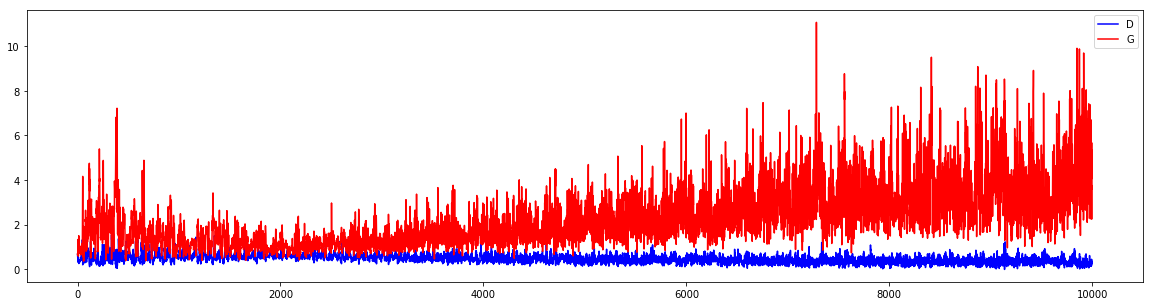

In [21]:
plt.figure(figsize=(20,5))
x = range(iterations)
plt.plot(x, d_losses, color='blue', label='D')
plt.plot(x, g_losses, color='r', label='G')
plt.legend()
plt.show()

Compare generated images with real MNIST images

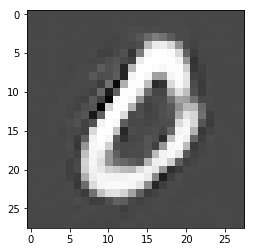

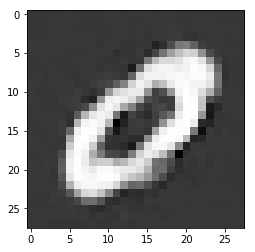

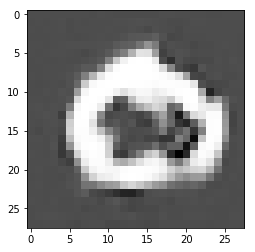

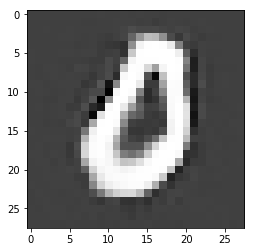

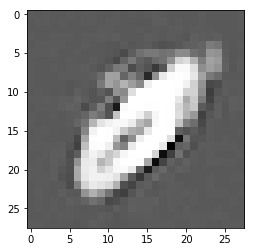

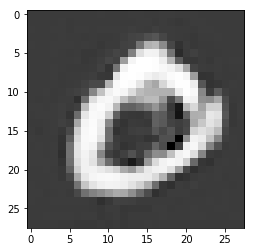

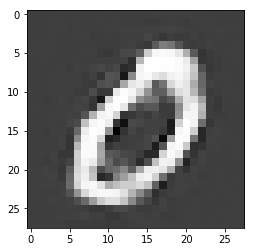

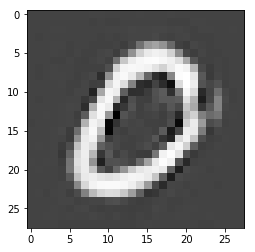

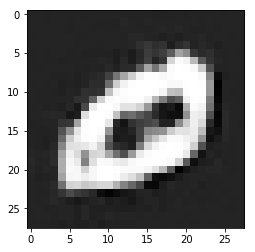

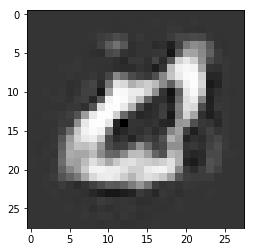

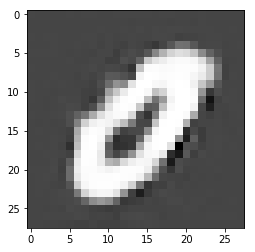

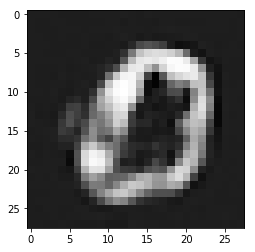

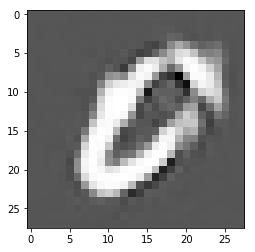

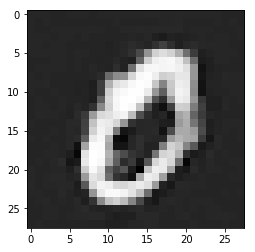

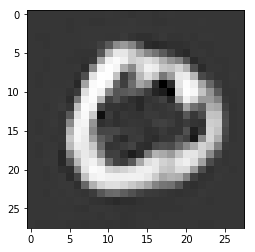

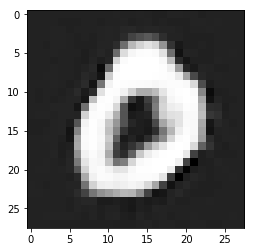

In [19]:
random_input = np.random.normal(size=(BATCH_SIZE, INPUT_SIZE))
generated_images = generator.predict(random_input)
for i in range(BATCH_SIZE):
    plt.imshow(generated_images[i].reshape((28,28)), cmap='gray')
    plt.show()

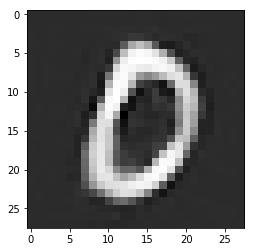

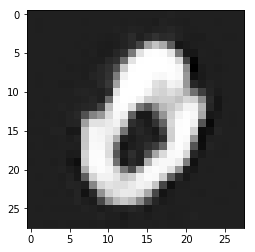

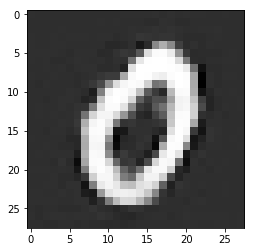

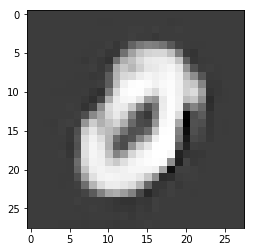

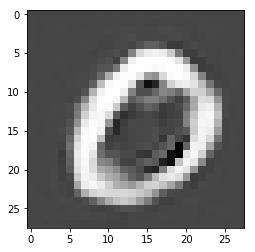

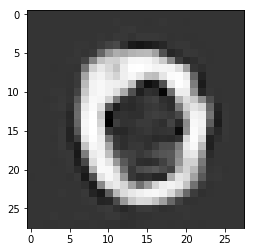

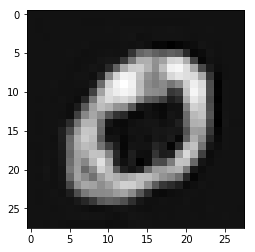

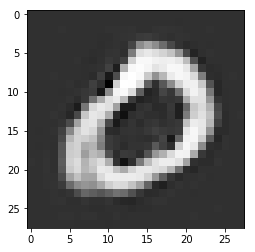

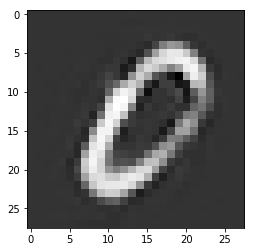

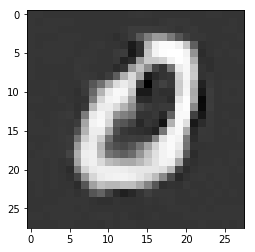

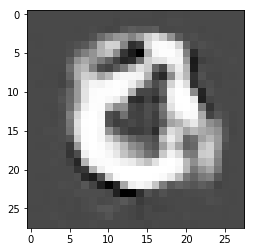

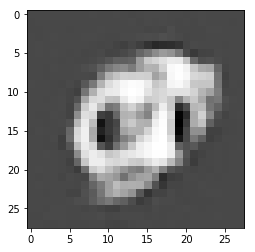

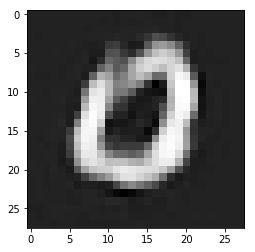

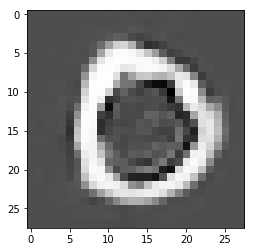

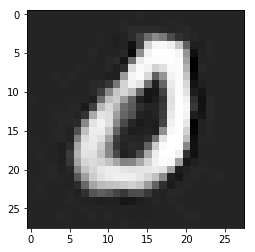

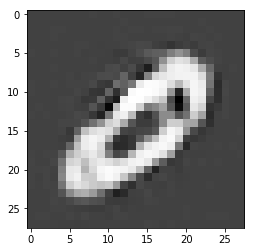

In [20]:
for i in range(BATCH_SIZE):
    plt.imshow(train_data[i].reshape((28,28)), cmap='gray')
    plt.show()